In [1]:
import os
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ee

import rasterio
import rasterio.plot
import osr
import gdal
import ogr
import shapely

from climata.usgs import DailyValueIO
from shapely.geometry import Point
from shapely.ops import cascaded_union

ee.Initialize()

In [2]:
# First, make a merged shapefile of hucs of different orders from 1802, 1803, 1804

In [3]:
huc_order = "8"
huc_str = "WBDHU{}.shp".format(huc_order)

huc4s = ["1802", "1803", "1804"]
hu4_dirs = [os.path.join("../nhd", x, "Shape") for x in os.listdir("../nhd") if "." not in x]

In [4]:
def find_hucs(dir, huc_str):
    shp_files = [os.path.join(dir,x) for x in os.listdir(dir) if huc_str in x if "xml" not in x]
    return shp_files

In [5]:
hu_shps = []

for i in hu4_dirs:
    hu_shps.append(find_hucs(i, huc_str)[0])
    
gdfs = []

for i in hu_shps:
    gdfs.append(gp.read_file(i))

In [6]:
rdf = gp.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

Text(0.5,1,'HU8s in CV drainage basins')

<Figure size 432x288 with 0 Axes>

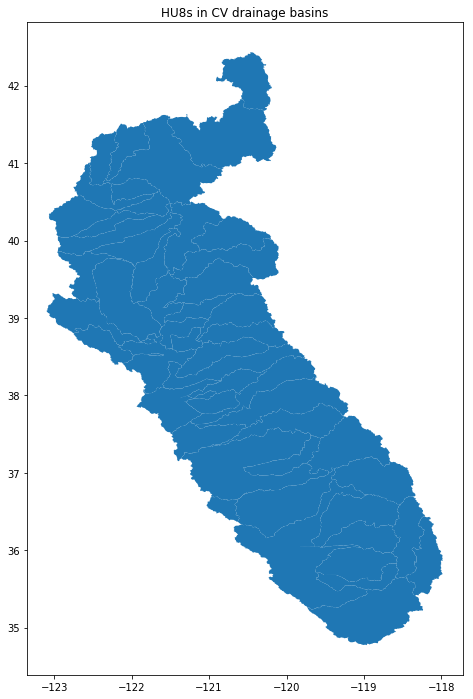

In [7]:
plt.figure()
rdf.plot(figsize = (15, 12))
plt.title("HU8s in CV drainage basins")

In [8]:
rdf.head()

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,States,HUC8,Name,Shape_Leng,Shape_Area,geometry
0,1,{325AFE07-3EAB-45C5-BCFB-2E559B2A3F24},None,None,None,None,2012-06-11,0,1205843.27,4879.88,CA,18020104,Sacramento-Stone Corral,4.198591,0.509093,POLYGON ((-122.2906857133291 39.77427483722067...
1,2,{0955D2B7-AA29-4EF6-981C-4E1E6D6F0D8D},None,None,None,None,2012-06-11,0,187210.67,757.62,CA,18020111,Lower American,1.736756,0.078450,POLYGON ((-121.1762908931839 38.87656663028076...
2,3,{60A4F8FB-1956-427B-8D5C-93C2BE16CDE0},None,None,None,None,2012-06-11,0,497156.05,2011.92,CA,18020115,Upper Stony,4.136618,0.210910,"POLYGON ((-122.5864025139118 39.863393500624, ..."
3,4,{FF586FCD-091E-44E8-AB6D-B2ED3F564209},None,None,None,None,2012-06-11,0,745638.03,3017.49,CA,18020116,Upper Cache,5.069704,0.313770,POLYGON ((-123.0089964320058 39.31981743792608...
4,5,{AF64664B-70CD-44FE-8B3F-D8CEF73DD780},None,None,None,None,2012-06-11,0,860756.27,3483.36,CA,18020125,Upper Yuba,4.325172,0.364474,POLYGON ((-120.8540494634757 39.75979056953486...


In [11]:
# rdf.to_file("../nhd/cv_hu10.shp")

cv = gp.read_file("../shape/cv.shp")

In [12]:
# Sierra side (eastern) huc8s from south to north: 
sierra_hu8s = ["18030003", "18030004", "18030005", "18030006", "18030007", # 1803 Tulare
               "18030012", "18030009", "18040001", "18040007", "18040008", 
               "18040010", "18040011", "18040012", "18040013", "18040014", # 1804 San Joaquin 
               "18040010", "18040011", "18040012", "18040013", "18040014",
               "18040009", 
               "18020111", "18020161", "18020126", "18020125", "18020159", # 1802 Sac
               "18020158", "18020157", "18020155", "18020154", "18020151",
               "18020153", "18020156"]

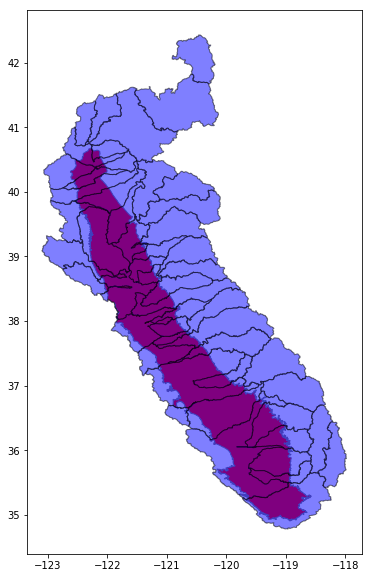

In [13]:
fig, ax = plt.subplots(figsize = (6, 10))
cv.plot(ax = ax, color = "red", edgecolor = "gray")
rdf.plot(ax = ax, color = "blue", alpha = 0.5, edgecolor='black')


In [14]:
def get_stremflow(huc8):
    
    '''
    call climata API supplying huc8 argument to get each gaging station within each basin 
    '''
    
    data =  DailyValueIO (
            start_date="1980-01-01", 
            end_date="2018-01-01",
            basin=huc8,
            parameter="00060",
            )
    
    qs = []
    ds = []
    lats = []
    lons = []
    ids = []

    for series in data:
        values = []
        dates = []
        lats.append(series.latitude)
        lons.append(series.longitude)
        ids.append(series.site_code)

        for row in series.data:
            values.append(row.value)
            dates.append(row.date)

        qs.append(values)
        ds.append(dates)
    
    geometry = [Point(xy) for xy in zip(lons, lats)]
    df = pd.DataFrame(geometry)
    crs = {'init': 'epsg:4326'}
    gdf = gp.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    return gdf, qs, ds, ids

In [19]:
gdfs = []
qs = []
ds = []
ids = []

for i in rdf['HUC8']:
    print (i)
    gdf, q, d, i = get_stremflow(i)
    gdfs.append(gdf)
    qs.append(q)
    ds.append(d)
    ids.append(i)


18020104
18020111
18020115
18020116
18020125
18020126
18020128
18020129
18020151
18020152
18020153
18020154
18020155
18020156
18020159
18020161
18020162
18020163
18020002
18020003
18020004
18020005
18020121
18020122
18020123
18020157
18020158
18020001
18040001
18040002
18040003
18040006
18040007
18040008
18040009
18040010
18040011
18040012
18040013
18040014
18040051
18030001
18030002
18030003
18030004
18030005
18030006
18030007
18030009
18030010
18030012


In [20]:
gdf_f = [item for sublist in gdfs for item in sublist]
q_f = np.array([item for sublist in qs for item in sublist])
d_f = np.array([item for sublist in ds for item in sublist])
ids_f = [item for sublist in ids for item in sublist]

In [21]:
pgdf = gp.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

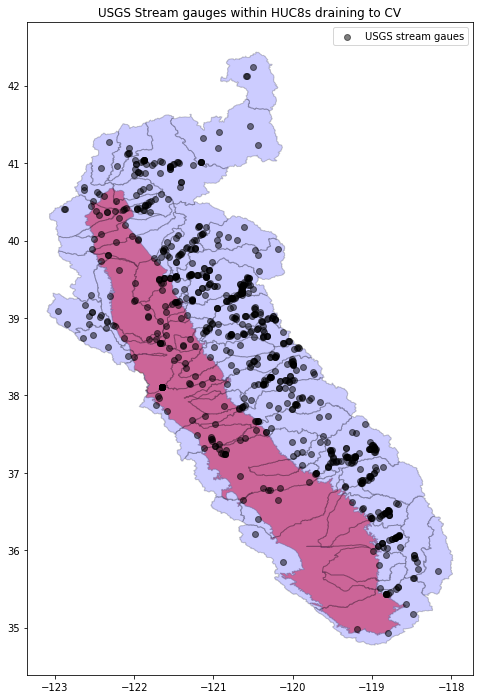

In [32]:
fig, ax = plt.subplots(figsize = (8, 12))
plt.title("USGS Stream gauges within HUC8s draining to CV")
cv.plot(ax = ax, color = "red",alpha = 0.5, edgecolor = "gray")
rdf.plot(ax = ax, color = "blue", alpha = 0.2, edgecolor='black')
pgdf.plot(ax=ax, marker="o", alpha=0.5, color = "black", label = "USGS stream gaues")
plt.legend()
plt.show()

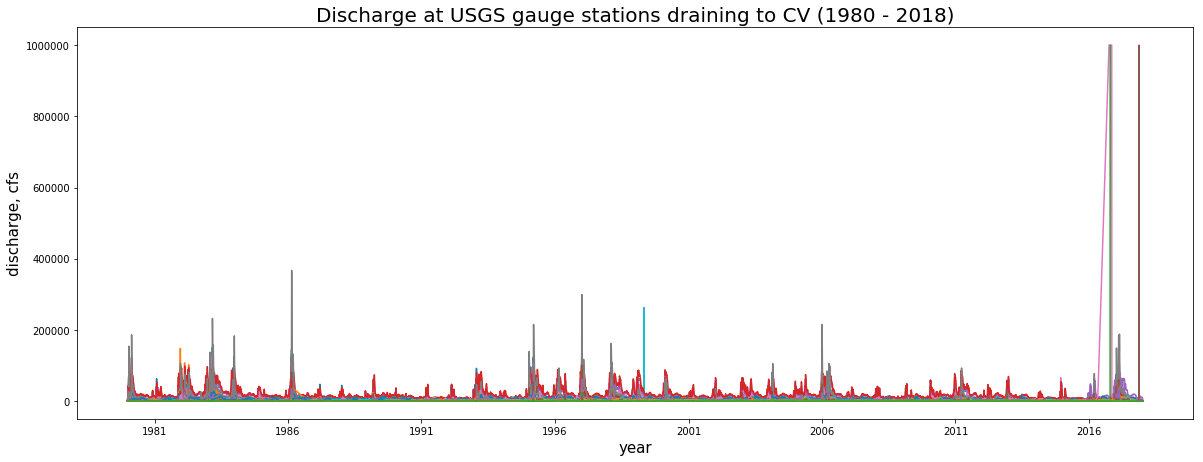

In [33]:
fig = plt.figure(figsize = (20,8))
ax = plt.subplot(111)

for i, x in enumerate(q_f):
    line = ax.plot(d_f[i],np.abs(q_f[i]), label = ids_f[i])
    
# ax.legend(loc='upper left',ncol=7, fancybox=True, prop={'size': 12})

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

plt.xlabel("year", size = 15)
plt.ylabel("discharge, cfs", size = 15)
plt.title("Discharge at USGS gauge stations draining to CV (1980 - 2018)", size = 20)
plt.show()

In [33]:
# Extract mean discharges from timeseries

In [25]:
means = []
for i, x in enumerate(q_f): 
    means.append(np.mean(x))
    
pgdf['mean'] = means

In [26]:
max_val = pgdf['mean'].max()
med_val = pgdf['mean'].median()
min_val = pgdf['mean'].min()

In [27]:
f1 = pgdf[pgdf['mean'] == max_val]
f2 = pgdf[pgdf['mean'] == med_val]
f3 = pgdf[pgdf['mean'] == min_val]


In [28]:
p1, p2, p3, p4 = np.percentile(pgdf['mean'],50), np.percentile(pgdf['mean'],75), np.percentile(pgdf['mean'],90), np.percentile(pgdf['mean'],99)

/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/matplotlib/collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


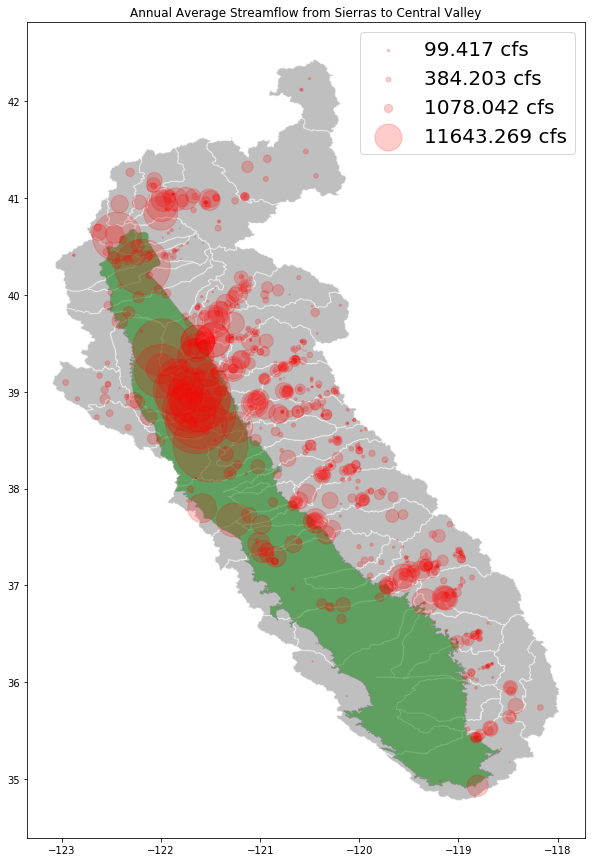

In [29]:
fig, ax = plt.subplots(1, figsize=(10,15))

plt.title("Annual Average Streamflow from Sierras to Central Valley")

# Plot the dfs 
rdf.plot(ax = ax, color = "gray", alpha = 0.5, edgecolor = "white")
cv.plot(ax = ax, color = "green",alpha = 0.5, edgecolor = "gray")
pgdf.plot(ax=ax, marker=".", alpha=0.2, c = "red", markersize = pgdf['mean'])

# Dummy objects for legend 
f3.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p1, label = "{} cfs".format(round(p1,3)))
f1.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p2, label = "{} cfs".format(round(p2,3)))
f1.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p3, label = "{} cfs".format(round(p3,3)))
f1.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p4, label = "{} cfs".format(round(p4,3)))

plt.legend(markerscale = 0.5, prop={'size': 20})

plt.show()

In [58]:
s = gp.read_file("../Shape/1802_4.shp")
sj = gp.read_file("../Shape/1804_4.shp")
t = gp.read_file("../Shape/1803_4.shp")
basins = gp.read_file("../Shape/ca_gw_basins.shp")

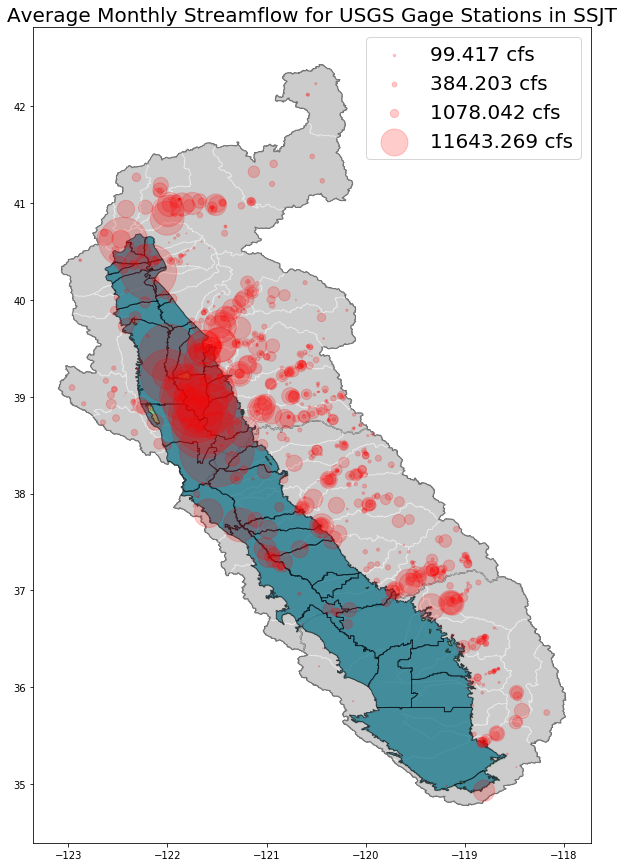

In [62]:
fig, ax = plt.subplots(1, figsize=(10,15))

plt.title("Average Monthly Streamflow for USGS Gage Stations in SSJT", size = 20)

# Plot the huc4s
s.plot(ax = ax, color = 'none', edgecolor = "black")
sj.plot(ax = ax, color = 'none', edgecolor = "black")
t.plot(ax = ax, color = 'none',   edgecolor = "black")

# Plot the dfs 
rdf.plot(ax = ax, color = "gray", alpha = 0.4, edgecolor = "white")
cv.plot(ax = ax, color = "green",alpha = 0.4, edgecolor = "gray")
basins.plot(ax = ax, alpha = 0.6, edgecolor = "black")
pgdf.plot(ax=ax, marker=".", alpha=0.2, c = "red", markersize = pgdf['mean'])

# Dummy objects for legend 
f3.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p1, label = "{} cfs".format(round(p1,3)))
f1.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p2, label = "{} cfs".format(round(p2,3)))
f1.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p3, label = "{} cfs".format(round(p3,3)))
f1.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p4, label = "{} cfs".format(round(p4,3)))

plt.legend(markerscale = 0.5, prop={'size': 20})

plt.savefig("../figs/ssjt_Qs.png")

plt.show()